# CS421: Introduction to Machine Learning
## Project: Customer Churn Prediction based on Customer Profile
### Exploratory Data Analysis
---

# 1. Setting up the notebook

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, SelectKBest

In [2]:
df = pd.read_csv("../data/BankChurners.csv")

In [3]:
# dropping irrelevant columns
df = df.drop(columns=["CLIENTNUM", "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1", "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"], axis=1)
df.head(1)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061


In [4]:
# tidy up and standardise column naming convention
tidied_cols = []
for col_name in df.columns:
    col_name = col_name.lower()
    if '_ct' in col_name:
        col_name = col_name.replace('_ct', '_count')
    if '_chng' in col_name:
        col_name = col_name.replace('_chng', '_change')
    tidied_cols.append( col_name )

df.columns = tidied_cols.copy()
df.columns

Index(['attrition_flag', 'customer_age', 'gender', 'dependent_count',
       'education_level', 'marital_status', 'income_category', 'card_category',
       'months_on_book', 'total_relationship_count', 'months_inactive_12_mon',
       'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal',
       'avg_open_to_buy', 'total_amt_change_q4_q1', 'total_trans_amt',
       'total_trans_count', 'total_count_change_q4_q1',
       'avg_utilization_ratio'],
      dtype='object')

### Functions

In [5]:
def export_png(xlabel, ylabel):
    """
    Exports plots into png format

    INPUTS:
        xlabel — feature name for x axis
        ylabel — feature name for y axis

    """
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    file_name = xlabel + "&" + ylabel + ".png"
    plt.savefig(file_name, dpi=600, transparent=False, bbox_inches="tight")
    
    print("Export successful")

In [6]:
def categorical_probability(column):
    """
    Calculates probability distribution of Existing Customer and Attrited Customer

    INPUTS:
        columns — DataFrame of a particular categorical variable
    
    OUTPUT:
        DataFrame with p_existing, p_default for each sub-category, sorted in p_default descending order
    """
    column_df = pd.crosstab(index=df[column], 
                               columns=df["attrition_flag"],
                                margins=True)


    column_unique = df[column].unique()
    all_cols = np.append(column_unique, "col_total")
    column_df.index = all_cols
    column_df.columns = ["attrited","existing", "row_total"]
    
    column_df['p_existing'] = column_df['existing'] / column_df['row_total']

    column_df['p_attrited'] = column_df['attrited'] / column_df['row_total']
    column_df['p_attrited'] = column_df['p_attrited'].round(4)
    column_df_probability = pd.DataFrame( [column_df['p_attrited'], column_df['p_existing']], columns=column_df.index ).T
    column_df_probability.sort_values(by=['p_attrited'], ascending=False, inplace=True)
    column_df_probability.drop(labels=['col_total'], inplace=True)
#     column_df_probability.drop(labels=['p_existing'], axis=1, inplace=True)
    return column_df_probability[:15]

# 2. Basic Exploration

In [7]:
df.shape

(10127, 20)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   attrition_flag            10127 non-null  object 
 1   customer_age              10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   income_category           10127 non-null  object 
 7   card_category             10127 non-null  object 
 8   months_on_book            10127 non-null  int64  
 9   total_relationship_count  10127 non-null  int64  
 10  months_inactive_12_mon    10127 non-null  int64  
 11  contacts_count_12_mon     10127 non-null  int64  
 12  credit_limit              10127 non-null  float64
 13  total_revolving_bal       10127 non-null  int64  
 14  avg_op

In [9]:
# check if there's any null/empty values in dataset
df.isna().sum()

attrition_flag              0
customer_age                0
gender                      0
dependent_count             0
education_level             0
marital_status              0
income_category             0
card_category               0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
contacts_count_12_mon       0
credit_limit                0
total_revolving_bal         0
avg_open_to_buy             0
total_amt_change_q4_q1      0
total_trans_amt             0
total_trans_count           0
total_count_change_q4_q1    0
avg_utilization_ratio       0
dtype: int64

### Standardise column names to small case

In [10]:
df.columns = [ col_name.lower() for col_name in df.columns ]

numerical = list(df.describe().columns)
categorical = [i for i in df.columns if i not in numerical and i != "Attrition_Flag"]

# 3. Exploring Numerical columns

### 3.1 Checking the scale of each column

In [11]:
df.describe()

,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_change_q4_q1,total_trans_amt,total_trans_count,total_count_change_q4_q1,avg_utilization_ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


### 3.2 Plotting distribution for numerical columns

array([[<AxesSubplot:title={'center':'customer_age'}>,
        <AxesSubplot:title={'center':'dependent_count'}>],
       [<AxesSubplot:title={'center':'months_on_book'}>,
        <AxesSubplot:title={'center':'total_relationship_count'}>],
       [<AxesSubplot:title={'center':'months_inactive_12_mon'}>,
        <AxesSubplot:title={'center':'contacts_count_12_mon'}>],
       [<AxesSubplot:title={'center':'credit_limit'}>,
        <AxesSubplot:title={'center':'total_revolving_bal'}>],
       [<AxesSubplot:title={'center':'avg_open_to_buy'}>,
        <AxesSubplot:title={'center':'total_amt_change_q4_q1'}>],
       [<AxesSubplot:title={'center':'total_trans_amt'}>,
        <AxesSubplot:title={'center':'total_trans_count'}>],
       [<AxesSubplot:title={'center':'total_count_change_q4_q1'}>,
        <AxesSubplot:title={'center':'avg_utilization_ratio'}>]],
      dtype=object)

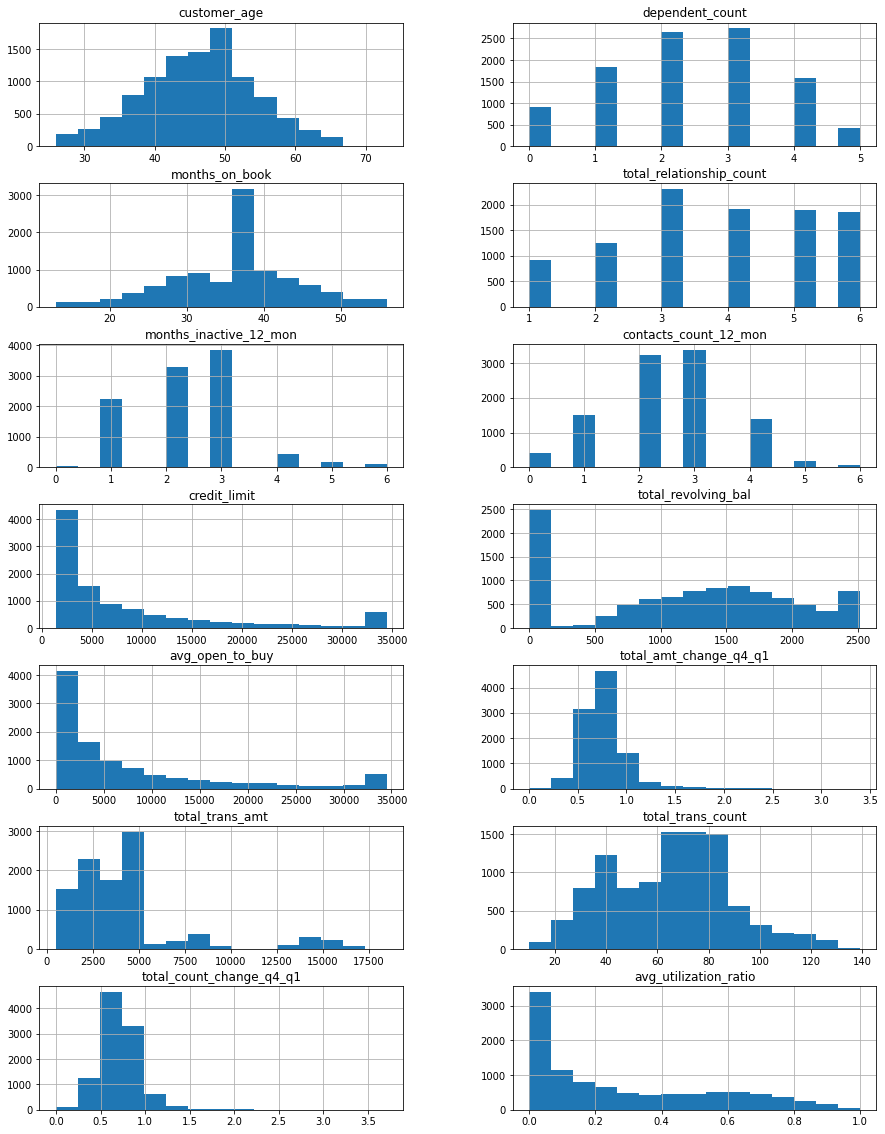

In [12]:
df[numerical].hist(bins=15, figsize=(15, 20), layout=(7,2))

### 3.3 Identifying skewed columns

In [13]:
skewed = {}

skewed_cols = df[numerical].skew()

for skew_val in skewed_cols:
    if skew_val > 1 or skew_val < -1:
        skewed[skewed_cols[ skewed_cols == skew_val ].index[0]] = round(skew_val, 3)
    
for key, val in skewed.items():
    print(key, val)

credit_limit 1.667
avg_open_to_buy 1.662
total_amt_change_q4_q1 1.732
total_trans_amt 2.041
total_count_change_q4_q1 2.064


### 3.4 Checking for collinearity

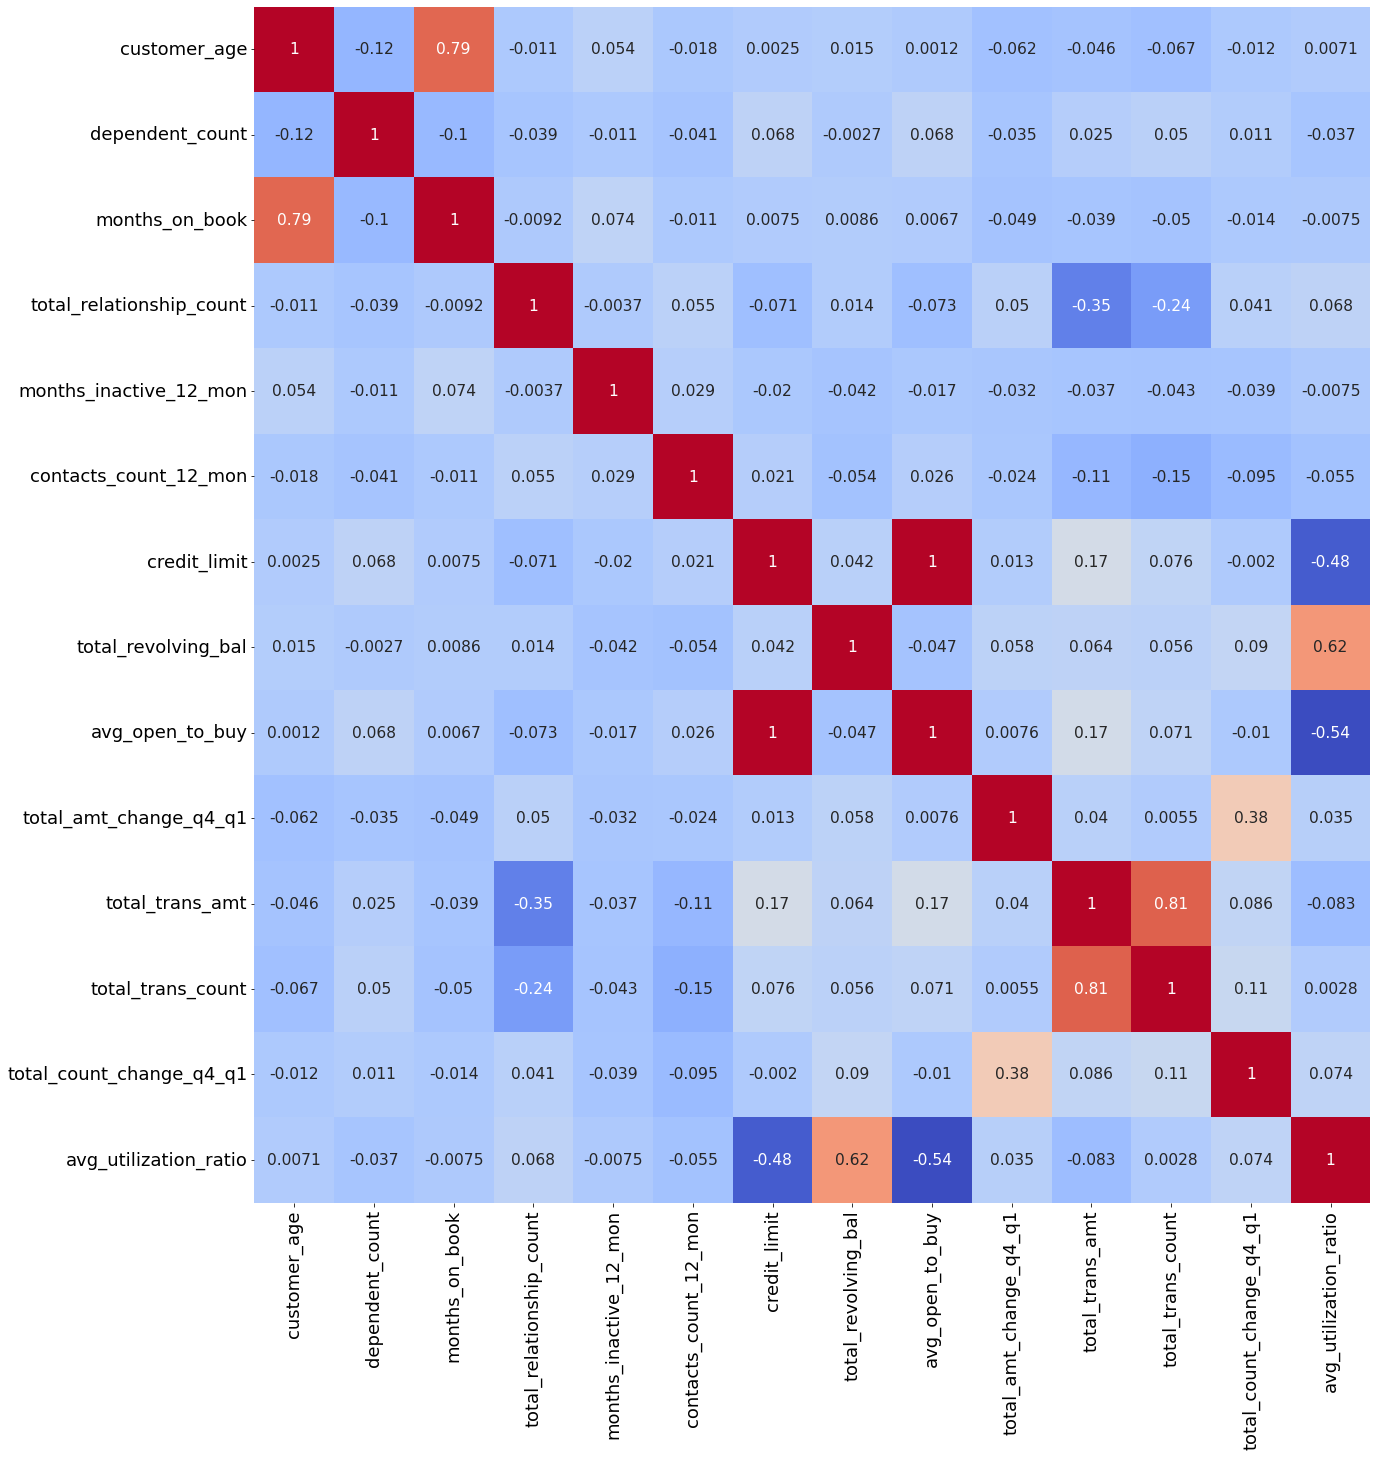

In [14]:
fig, ax = plt.subplots( figsize = (20,22) )
res = sns.heatmap( df.corr(), cmap='coolwarm', annot=True, ax = ax, annot_kws={"size": 15.5}, cbar=False)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18, rotation=90)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)

# plt.savefig("correlation_matrix_heatmap.png", transparent=False, dpi=500)
plt.show()

### 3.5 Plotting pairwise scatterplots

In [15]:
plt.figure(figsize=(20, 20))

# test = sns.pairplot(df[numerical])
# test.set_xticklabels(test.get_xmajorticklabels(), fontsize = 18, rotation=90)
# test.set_yticklabels(test.get_ymajorticklabels(), fontsize = 18)

# test.savefig('pairplots-dpi400.png', dpi=400, bbox_inches="tight")
# plt.show()

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

#### Closer look at collinear features

In [16]:
def collinear_features(feature_x, feature_y):
    print('Correlation:', round( df[[feature_x, feature_y]].corr().iloc[0, 1], 5) )
    fig, ax = plt.subplots( figsize = (8,6) )
    sns.scatterplot(x = feature_x, y = feature_y, data = df)
    
    # Export plots to .png
#     export_png(feature_x, feature_y)

Correlation: 0.99598


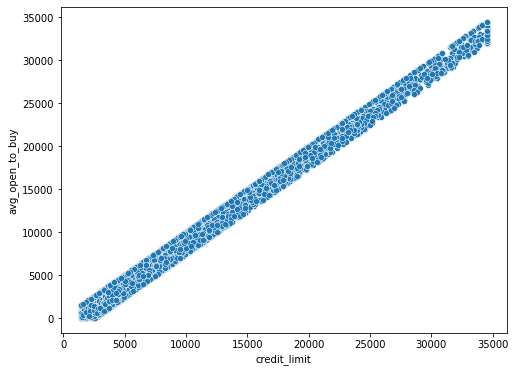

In [17]:
collinear_features('credit_limit', 'avg_open_to_buy')

Correlation: 0.80719


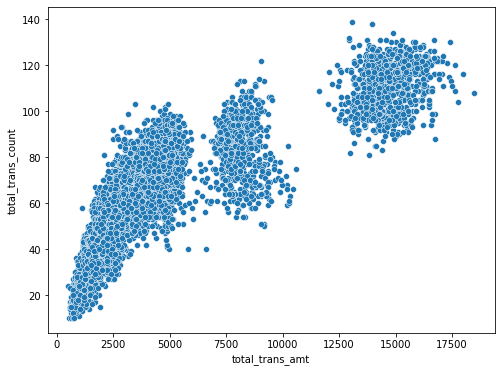

In [18]:
collinear_features('total_trans_amt', 'total_trans_count')

Correlation: 0.78891


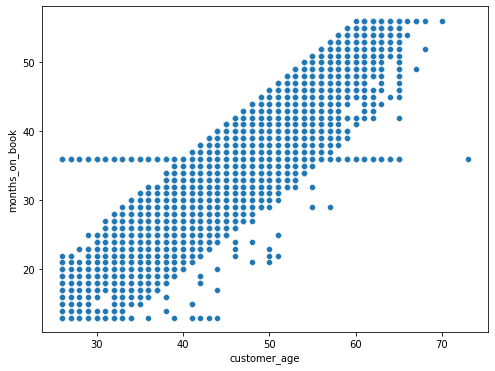

In [19]:
collinear_features('customer_age', 'months_on_book')

Correlation: 0.62402


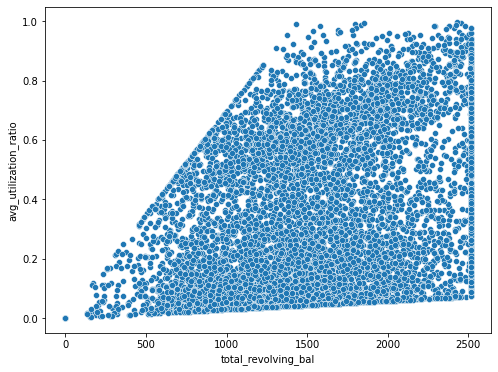

In [20]:
collinear_features('total_revolving_bal', 'avg_utilization_ratio')

Correlation: -0.53881


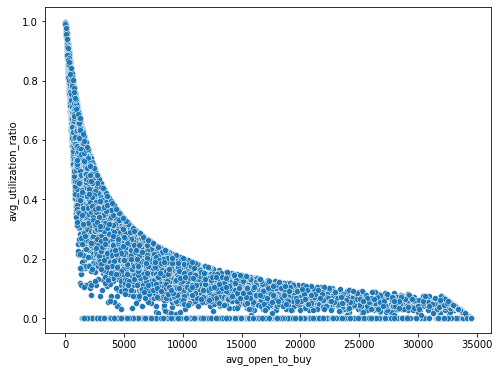

In [21]:
collinear_features('avg_open_to_buy', 'avg_utilization_ratio')

Correlation: -0.48297


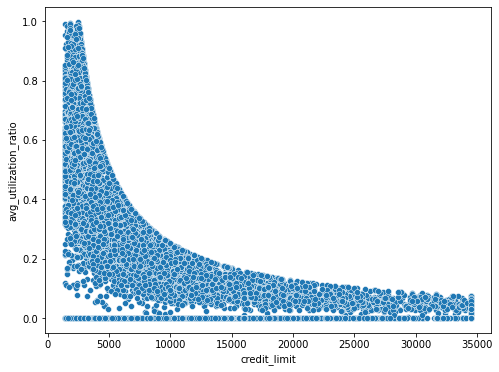

In [22]:
collinear_features('credit_limit', 'avg_utilization_ratio')

Correlation: 0.38419


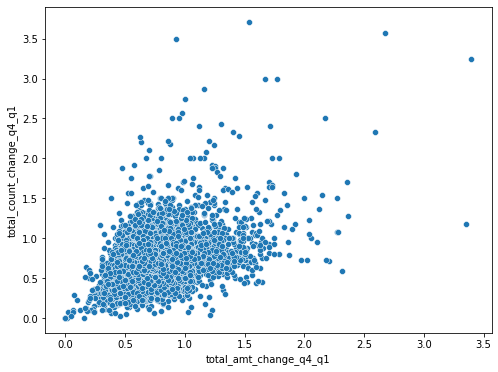

In [23]:
collinear_features('total_amt_change_q4_q1', 'total_count_change_q4_q1')

# 3. Exploring Categorical Features

### 3.1 Display value_counts for each categorical column

In [24]:
for cat in categorical:
    print('Variable:', cat)
    print('Unique values:', df[cat].nunique() )
    print( df[cat].value_counts() )
    print('==========================')
    print()

Variable: attrition_flag
Unique values: 2
Existing Customer    8500
Attrited Customer    1627
Name: attrition_flag, dtype: int64

Variable: gender
Unique values: 2
F    5358
M    4769
Name: gender, dtype: int64

Variable: education_level
Unique values: 7
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: education_level, dtype: int64

Variable: marital_status
Unique values: 4
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: marital_status, dtype: int64

Variable: income_category
Unique values: 6
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: income_category, dtype: int64

Variable: card_category
Unique values: 4
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: card_category, dtype: int64



### 3.2 Plot histogram

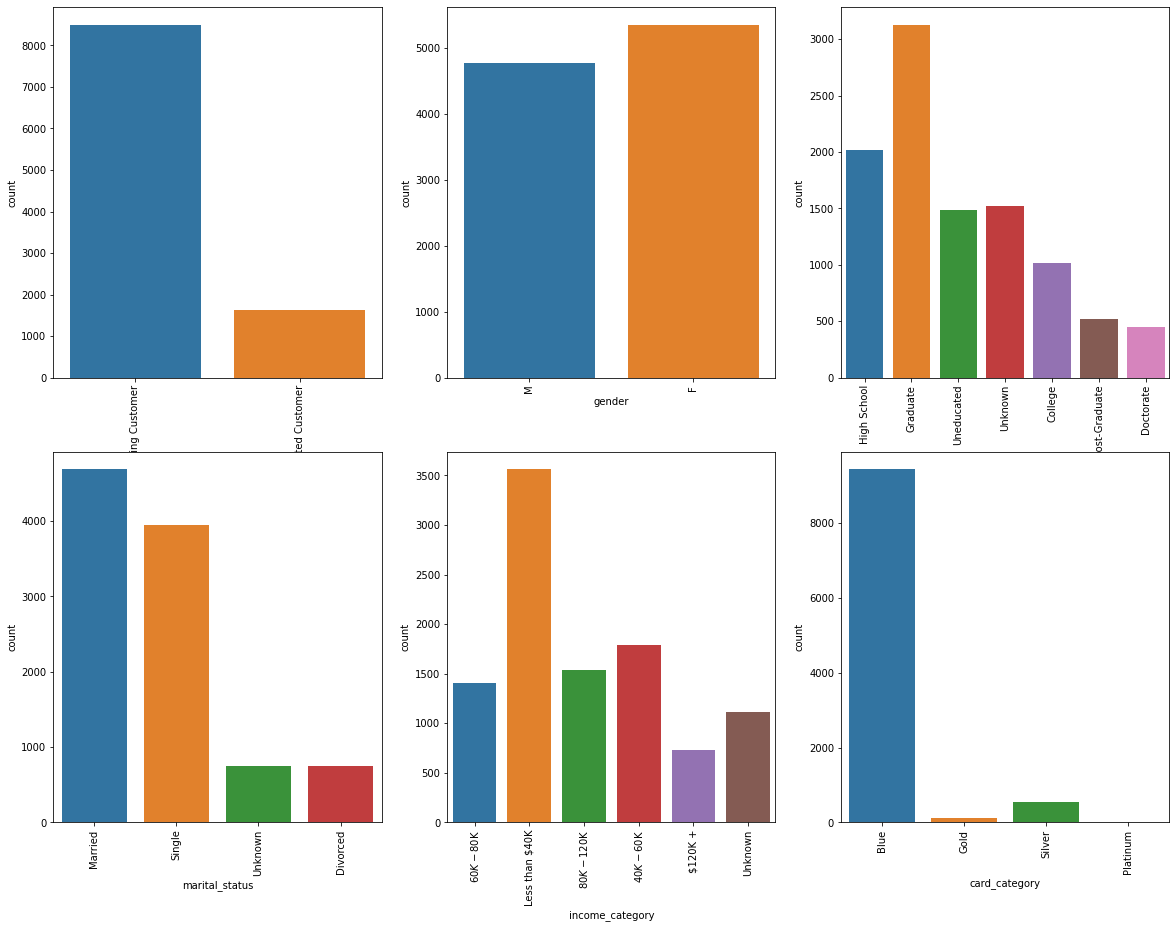

In [25]:
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(x=df[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

# 4. Bivariate plots

### 4.1 Boxplot for each numerical column conditioned on `attrition_flag`

In [66]:
df.head()

,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_change_q4_q1,total_trans_amt,total_trans_count,total_count_change_q4_q1,avg_utilization_ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


<AxesSubplot:xlabel='attrition_flag', ylabel='avg_utilization_ratio'>

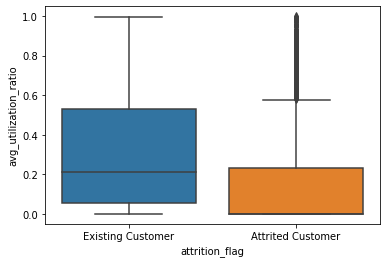

In [26]:
sns.boxplot(x='attrition_flag', y='avg_utilization_ratio', data=df)

Mean for: total_trans_amt 
Existing customers: 4654.655882352941
Attrited customers: 3095.025814382299


<AxesSubplot:xlabel='attrition_flag', ylabel='total_trans_amt'>

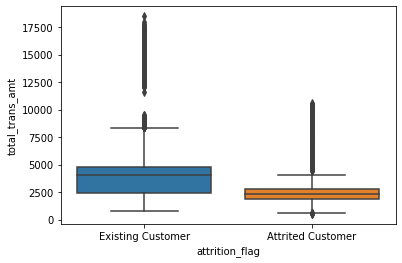

In [74]:
existing_customers = df[ df['attrition_flag'] == 'Existing Customer']
attrited_customers = df[ df['attrition_flag'] == 'Attrited Customer']

print('Mean for: total_trans_amt ')
print( 'Existing customers:', existing_customers['total_trans_amt'].mean() )
print( 'Attrited customers:', attrited_customers['total_trans_amt'].mean() )
sns.boxplot(x='attrition_flag', y='total_trans_amt', data=df)

Mean for: total_count_change_q4_q1 
Existing: 0.7424341176470589
Attrited: 0.5543859864781807


<AxesSubplot:xlabel='attrition_flag', ylabel='total_count_change_q4_q1'>

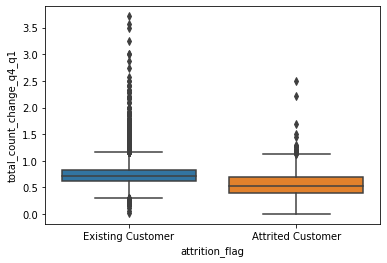

In [78]:
existing_customers = df[ df['attrition_flag'] == 'Existing Customer']
attrited_customers = df[ df['attrition_flag'] == 'Attrited Customer']

print('Mean for: total_count_change_q4_q1 ')
print( 'Existing:', existing_customers['total_count_change_q4_q1'].mean() )
print( 'Attrited:', attrited_customers['total_count_change_q4_q1'].mean() )
sns.boxplot(x='attrition_flag', y='total_count_change_q4_q1', data=df)

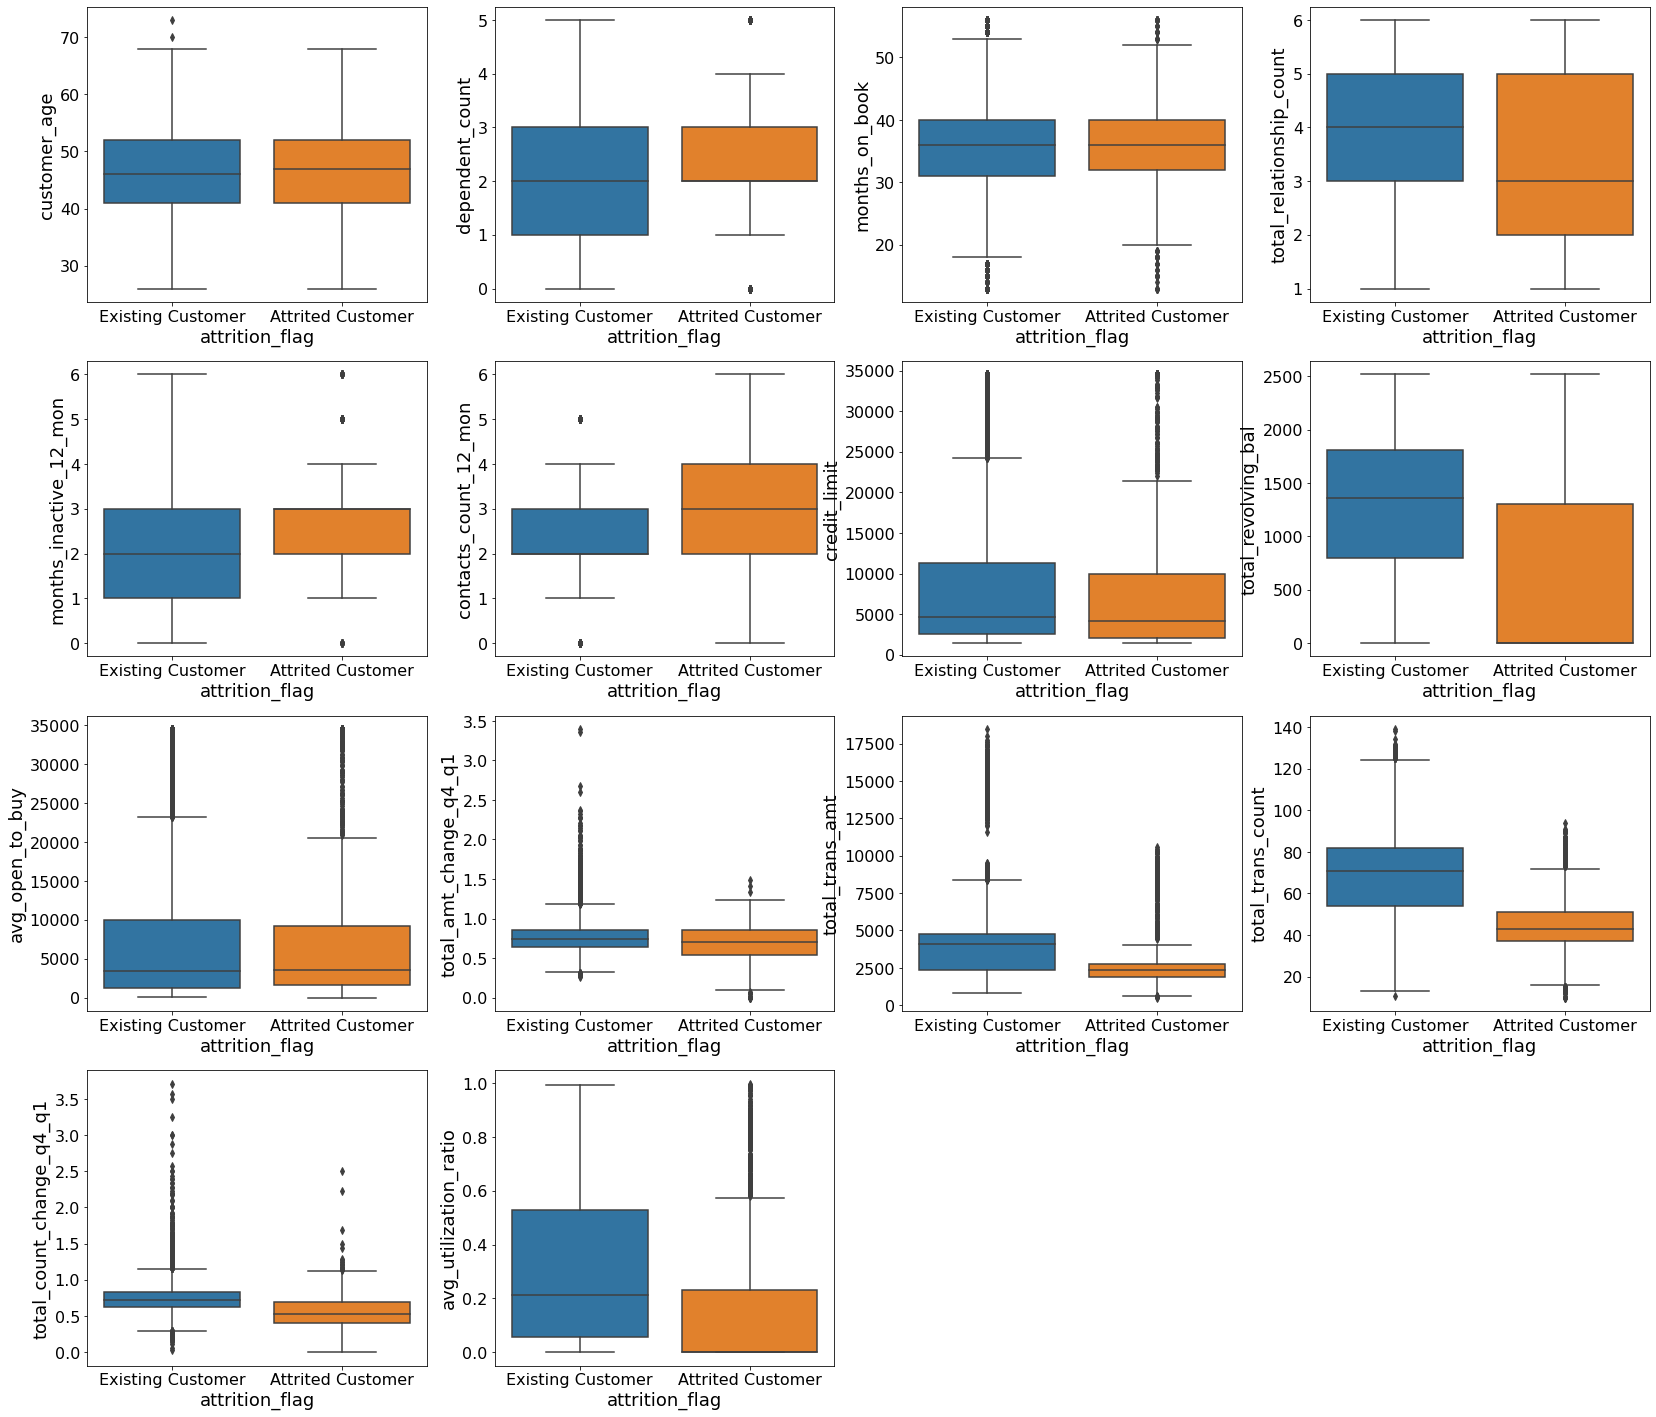

In [27]:
plt.figure(figsize=(28, 25))
for i in range(len(numerical) ):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(x='attrition_flag', y=numerical[i], data=df)
    plt.xlabel('attrition_flag', fontsize=18)
    plt.ylabel(numerical[i], fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
plt.show()

Mean for: total_revolving_bal 
Existing: 1256.6041176470587
Attrited: 672.8229870928088


<AxesSubplot:xlabel='attrition_flag', ylabel='total_revolving_bal'>

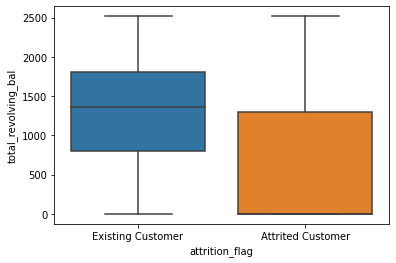

In [77]:
existing_customers = df[ df['attrition_flag'] == 'Existing Customer']
attrited_customers = df[ df['attrition_flag'] == 'Attrited Customer']

print('Mean for: total_revolving_bal ')
print( 'Existing:', existing_customers['total_revolving_bal'].mean() )
print( 'Attrited:', attrited_customers['total_revolving_bal'].mean() )
sns.boxplot(x='attrition_flag', y='total_revolving_bal', data=df)

In [60]:
existing_customers = df[ df['attrition_flag'] == 'Existing Customer']
attrited_customers = df[ df['attrition_flag'] == 'Attrited Customer']

print('existing')

print( existing_customers['total_revolving_bala'].mean() )
print()
print()
print('attrited')

print( attrited_customers['months_inactive_12_mon'].mean() )

existing
2.273764705882353


attrited
2.693300553165335


(array([-2500.,     0.,  2500.,  5000.,  7500., 10000., 12500., 15000.,
        17500., 20000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

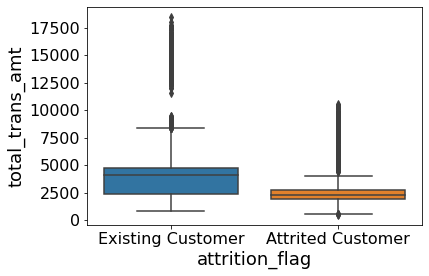

In [64]:
feature = 'total_trans_amt'

sns.boxplot(x='attrition_flag', y=feature, data=df)
plt.xlabel('attrition_flag', fontsize=18)
plt.ylabel(feature, fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

### 4.2 Calculating Conditional Probability of categorical column conditioned on `attrition_flag`

In [28]:
# import dataframe_image as dfi
# pd.options.display.precision = 4
# pd.set_option('display.precision', 4)

# for cat in categorical[1:]:
#     table = categorical_probability(cat)
#     cm = sns.color_palette("crest", as_cmap=True)
#     styled_table = table.style.background_gradient(cmap=cm)
#     display(styled_table)
#     print(cat, 'conditioned on attrition_flag')

    
# #    # Export DataFrame as image
# #     name = cat + '.png'
# #     dfi.export(styled_table, name)

# 5. Multivariate Plots
### 5.1 3D Boxplots of categorical columns against numerical columns across attrition_flag

<AxesSubplot:xlabel='card_category', ylabel='total_revolving_bal'>

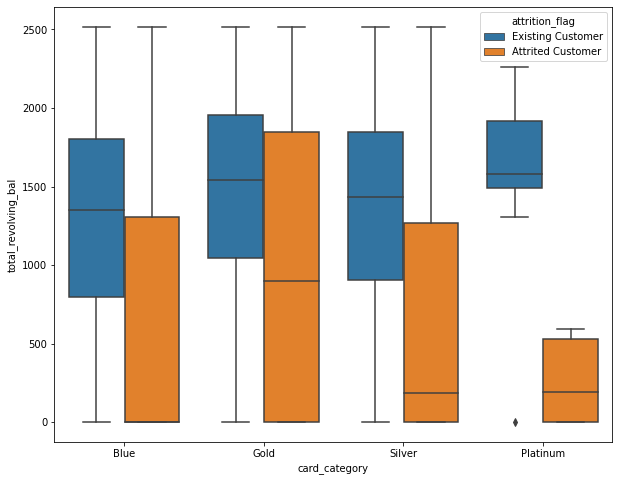

In [29]:
# Total revolving balance across card_categories

fig, ax = plt.subplots( figsize = (10,8) )
sns.boxplot(x = 'card_category', y='total_revolving_bal', hue='attrition_flag', data = df)

# export_png('card_category', 'total_revolving_bal')

<AxesSubplot:xlabel='card_category', ylabel='contacts_count_12_mon'>

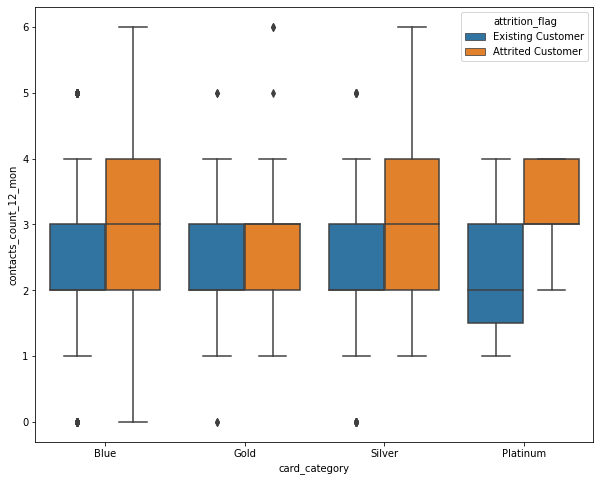

In [30]:
# Those who called the bank more times have a higher chance of attrition

fig, ax = plt.subplots( figsize = (10,8) )
sns.boxplot(x = 'card_category', y='contacts_count_12_mon', hue='attrition_flag', data = df)

<AxesSubplot:xlabel='card_category', ylabel='total_trans_count'>

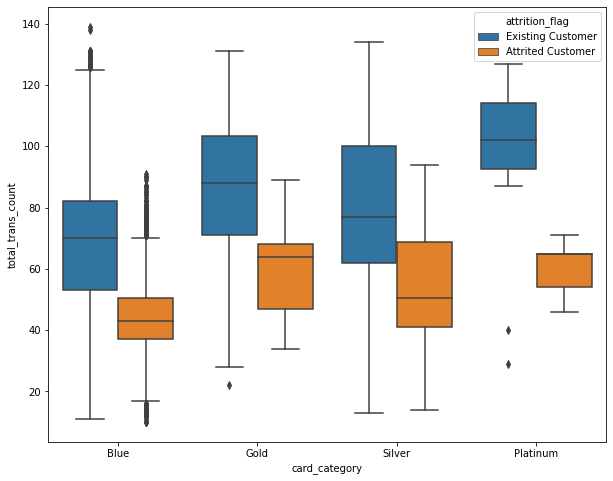

In [31]:
# Those who spent less on their card are more likely to attrit

fig, ax = plt.subplots( figsize = (10,8) )
sns.boxplot(x = 'card_category', y='total_trans_count', hue='attrition_flag', data = df)

# export_png('marital_status', 'total_trans_count')

<AxesSubplot:xlabel='income_category', ylabel='total_revolving_bal'>

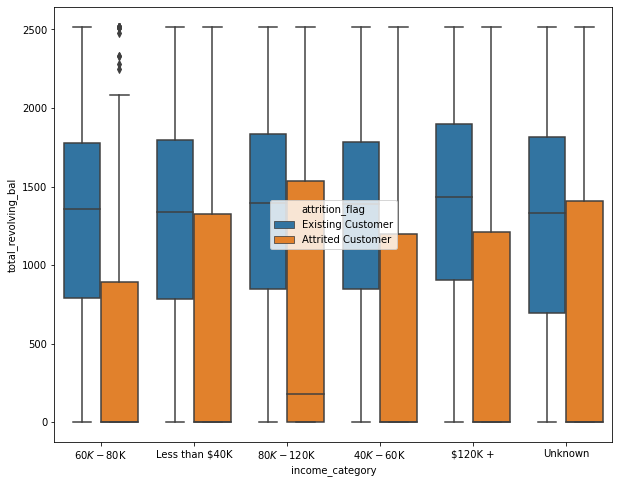

In [32]:
fig, ax = plt.subplots( figsize = (10,8) )
sns.boxplot(x = 'income_category', y='total_revolving_bal', hue='attrition_flag', data = df)

# export_png('marital_status', 'total_trans_count')